## https://umap-learn.readthedocs.io/en/latest/clustering.html

In [20]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

In [21]:
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [22]:
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(int)

## UMAP을 활용한 decomposition

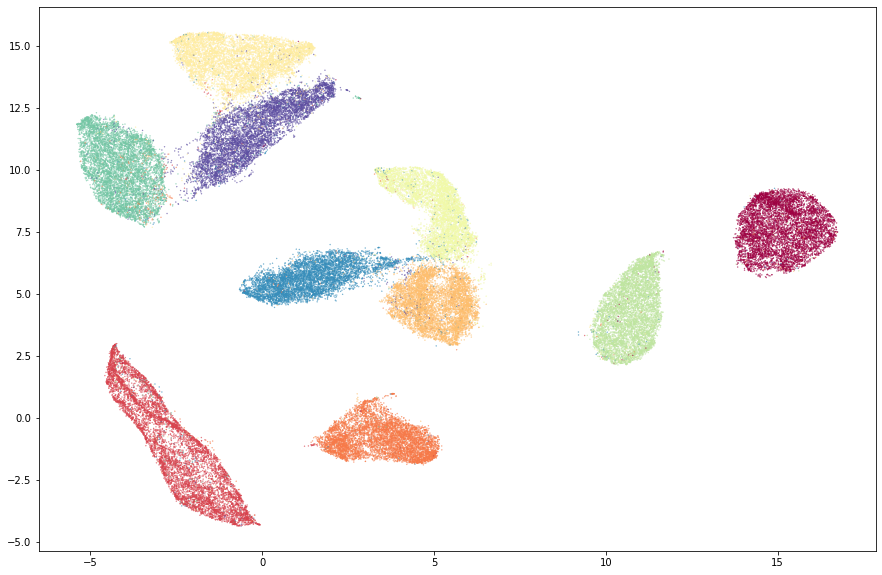

In [55]:
plt.figure(figsize=(15,10))
standard_embedding = umap.UMAP().fit_transform(mnist.data)
plt.scatter(standard_embedding[:,0], standard_embedding[:,1], c=mnist.target.astype(int), s=0.1, cmap='Spectral');

## K-means를 이용한 clsutering 
- k-means을 이용한 원본데이터에서 clustering이 36퍼 정도 밖에 일치하지않음.
- K-Means는 확실히 무작위가 아니었지만 진정한 레이블을 완벽하게 복구하는 데는 꽤 먼 길이었습니다.
- 문제의 일부는 대부분 구형 클러스터를 가정한 중심을 기반으로 하는 K-평균이 작동하는 방식입니다. 
- 이는 K-평균이 자릿수 클래스 전반에 걸쳐 급격한 분할을 일으키는 원인이 됩니다. 

In [24]:
kmeans_labels = cluster.KMeans(n_clusters=10).fit_predict(mnist.data)

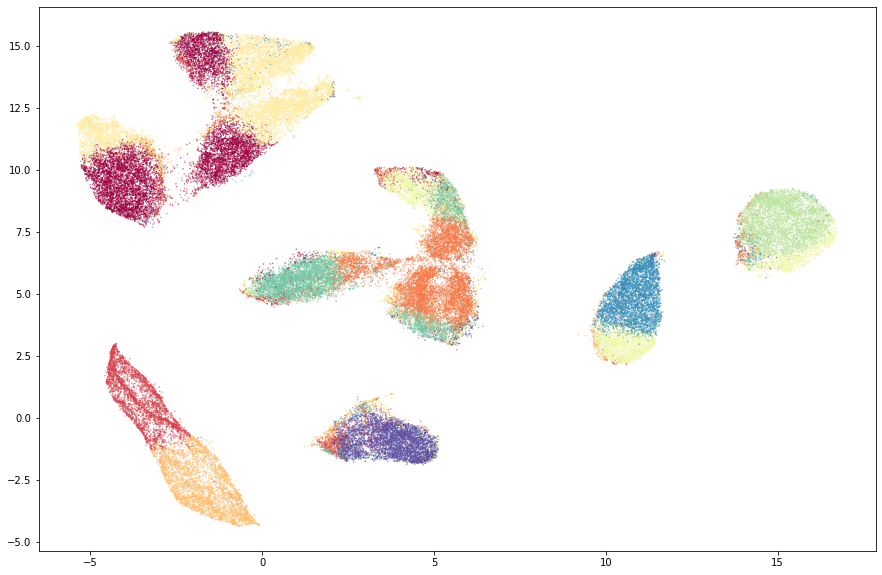

In [56]:
plt.figure(figsize=(15,10))
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=kmeans_labels, s=0.1, cmap='Spectral');

In [39]:
(adjusted_rand_score(mnist.target, kmeans_labels),adjusted_mutual_info_score(mnist.target, kmeans_labels))

(0.36576213396498314, 0.49988485174194935)

## HBSCAN(밀도기반 알고리즘)적용 (k-means 문제점 개선 예상)

In [26]:
pca = PCA(n_components=0.8).fit(lowd_mnist)
print('80%를 맞추는 주성분 개수:',pca.n_components_)

80%를 맞추는 주성분 개수: 16


In [27]:
lowd_mnist = PCA(n_components=30).fit_transform(mnist.data)
hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500).fit_predict(lowd_mnist)

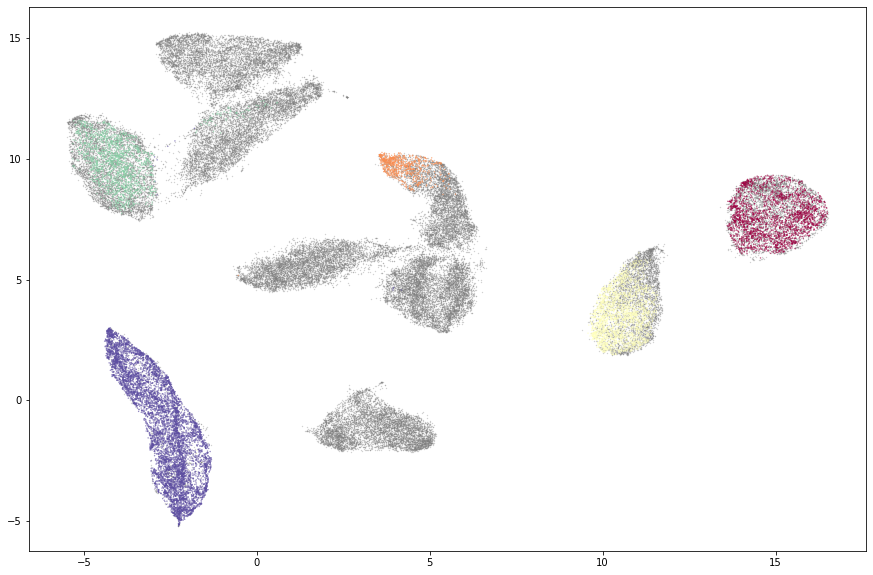

In [10]:
clustered = (hdbscan_labels >= 0)
plt.figure(figsize=(15,10))
plt.scatter(standard_embedding[~clustered, 0], #~clustered: ~:not의 의미, 즉 clustered가 아닌것: gray로 표시됨.
            standard_embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=hdbscan_labels[clustered],
            s=0.1,
            cmap='Spectral');

In [40]:
(adjusted_rand_score(mnist.target, hdbscan_labels),adjusted_mutual_info_score(mnist.target, hdbscan_labels))

C:\Users\jihoon.park\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:390: RuntimeWarning: overflow encountered in longlong_scalars
  (tp + fp) * (fp + tn))


(-0.4186010326664084, 0.28790357065563743)

### 사용되어진 데이터(채색된)에서 기존 label과 일치도 계산
- 99.5% 이나, 전체 데이터에서 사용된 비율이 15.25% 뿐이 안된다.

In [44]:
clustered = (hdbscan_labels >= 0)
(adjusted_rand_score(mnist.target[clustered], hdbscan_labels[clustered]),adjusted_mutual_info_score(mnist.target[clustered], hdbscan_labels[clustered]))

(0.9958802351198612, 0.9903629370797667)

In [45]:
np.sum(clustered) / mnist.data.shape[0]

0.1525

## 위 접근방식의 문제점
- 문제는 밀도 기반 클러스터링 알고리즘으로서 HDBSCAN이 차원의 저주를 겪는 경향이 있다.
- 고차원 데이터는 더 많은 밀도를 생성하기 위해 더 많은 관찰 샘플이 필요
- 데이터의 차원을 더 줄일 수 있다면 밀도를 더 분명하게 만들고 HDBSCAN이 데이터를 클러스터링하는 것을 훨씬 쉽게 만들 수 있습니다.
- 문제는 이것을 하기 위해 PCA를 사용하는 것이 문제가 될 것이라는 점입니다.
- 50개의 차원을 줄이면 여전히 데이터의 많은 분산이 설명되나, 더 줄이면 차원의 저주에 뭉쳐있는 밀도를 반영할 방법이없다.
- 따라서 이런문제를 해결하기 위해서는 <b>강력한 manifold</b>가 필요하다!

# UAMP을 이용한 클러스터링 향상
- UMAP의 한 가지 이점은 2차원으로만 줄일 필요가 없다는 것입니다.
- 목표가 시각화가 아니라 클러스터링이고 UMAP의 성능 비용이 최소화되기 때문에 대신 10차원으로 줄일 수 있습니다. 
- MNIST는 매우 단순한 데이터 세트이므로 실제로는 2차원으로만 압축할 수 있지만 일반적으로 다른 임베딩 차원 옵션을 탐색해야 합니다.
- <b>큰 n_neighbors (15->30), 작은 min_dist (0)</b>
- 노이즈보다 구조적인 구조에 초점을 맞추고, 조밀하게 데이터를 묶어서 밀도를 높이길 바란다. <b>원하는것이 밀도이기때문에!</b>

In [67]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(mnist.data)

### 시각화 결과를 보면, 클러스터 내에서 포인트를 더 밀접하게 묶는것을 확인가능

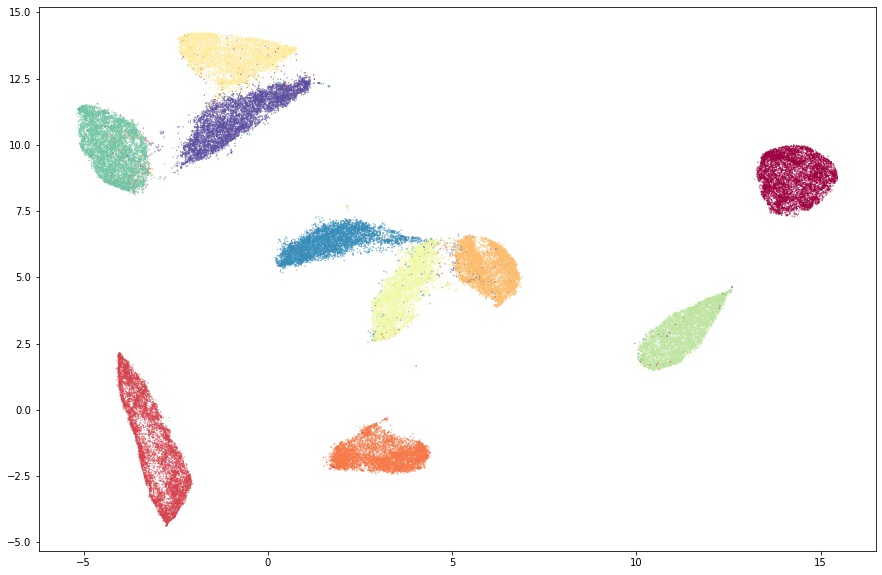

In [68]:
plt.figure(figsize=(15,10))
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=mnist.target, s=0.1, cmap='Spectral');

### 이 클러스터링의 목적은 embedding이 목적으로 이것을 이용하여 HDBSCAN을 진행해야한다!

In [69]:
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(clusterable_embedding)

## clustered가 아닌이 gray로 채색됬는데 아에 안보인다!!!

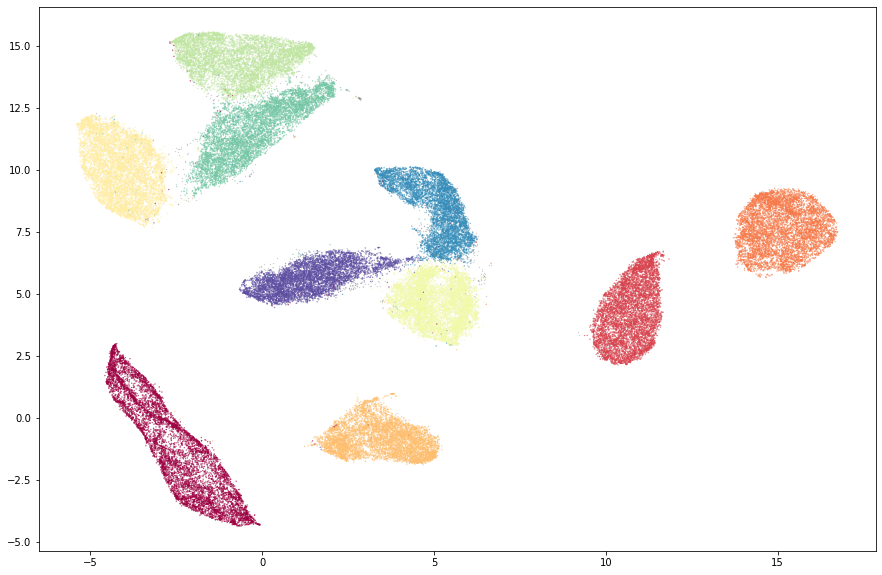

In [70]:
plt.figure(figsize=(15,10))
clustered = (labels >= 0)
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral');

## UMAP을 밀도보존 embedding으로 사용한뒤 HDBSCAN을 했을때,
## 향상된 결과값 (93%)와 사용정도 (15->99%)를 확인하라!

In [71]:
adjusted_rand_score(mnist.target, labels), adjusted_mutual_info_score(mnist.target, labels)

(0.9232275540733437, 0.9082508838442571)

In [74]:
clustered = (labels >= 0)
(
    adjusted_rand_score(mnist.target[clustered], labels[clustered]),
    adjusted_mutual_info_score(mnist.target[clustered], labels[clustered])
)

(0.9314017387804523, 0.9186578512736847)

In [75]:
np.sum(clustered) / mnist.data.shape[0]

0.9918571428571429